# Model Analysis

In [113]:
from glob import glob
from pathlib import Path
import scipy.sparse as sp
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
from packages.TPPMI.ppmi_model import PPMIModel
from packages.TPPMI.tppmi_model import TPPMIModel

from embedding_visualization import plot_temporal_changing_embedding, \
    plot_cosine_similarity, plot_word_vectors_tppmi, plot_cosine_similarity_tppmi

## Cade

In [114]:
model_path = Path("model/")
ppmi_path = Path(f"data/ppmi-matrices")

In [115]:
model_static = Word2Vec.load(str(model_path / "static/word2vec.model"))

In [116]:
def print_most_similar_cade(models, target_word, top_n=3):
    print(f"Word: {target_word}")
    for key, value in models.items():
        print(f"Month: {key.split('_')[1].capitalize()}")
        try:
            print(value.wv.most_similar(target_word, topn=top_n))
        except KeyError:
            print(f"{target_word} not in vocab")
        print("--------------------------------")

## Load models for months

### Cade

In [117]:
model_path_monthly = model_path / "monthly"
model_filenames = glob(str(model_path_monthly / "*.model"))

In [118]:
models_monthly = {f"model_{model_file.split('_')[1][0:3].lower()}":Word2Vec.load(model_file) for model_file in tqdm(model_filenames)}

  0%|          | 0/11 [00:00<?, ?it/s]

In [119]:
models_monthly.keys()

dict_keys(['model_sep', 'model_jan', 'model_dec', 'model_jul', 'model_oct', 'model_jun', 'model_aug', 'model_mar', 'model_nov', 'model_feb', 'model_apr'])

Order the models

In [120]:
order = ['jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']
month_codes = {"jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12, "jan": 1, "feb": 2, "mar": 3, "apr": 4}

# Sort the keys based on the desired month order
sorted_keys = sorted(models_monthly.keys(), key=lambda x: order.index(x.split('_')[1]))

# Create a sorted dictionary using a dictionary comprehension
models_monthly = {key: models_monthly[key] for key in sorted_keys}

### TPPMI

In [121]:
# Get names of the files
ppmi_data_filenames = sorted(glob(str(ppmi_path / "*.npz"))) # contains ppmi data
ppmi_vocab_filenames = sorted(glob(str(ppmi_path / "*.pkl"))) # contains vocab (column- and rownames)

In [122]:
import pickle

ppmi_matrices = {}

for filenames in zip(ppmi_vocab_filenames, ppmi_data_filenames):
    ppmi_matrix = sp.load_npz(filenames[1])
    with open(filenames[0], "rb") as f:
        vocab = pickle.load(f)
    key = filenames[0].split("ppmi-")[2][0:2]
    ppmi_matrices[key] = {"ppmi_matrix" : ppmi_matrix, "vocab": vocab}

In [89]:
ppmi_matrices.keys()

dict_keys(['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', '12'])

Create ppmi_model objects

In [90]:
ppmi_models = {key: PPMIModel.construct_from_data(ppmi_data["ppmi_matrix"], ppmi_data["vocab"]) for key, ppmi_data in ppmi_matrices.items()}

In [91]:
tppmi_model = TPPMIModel(ppmi_models)

In [92]:
print(f"Size of the vocabulary: {tppmi_model.get_vocabulary_size()}")

Size of the vocabulary: 26301


## Release of Brittney Griner

### Overview

On December 8, 2022, Russia and the United States conducted a prisoner exchange, trading Brittney Griner, an American basketball player, for Viktor Bout, a Russian arms dealer. Griner, a WNBA champion star and Team USA Olympic athlete, had been convicted of smuggling and possession of cannabis in Russia earlier in 2022 and sentenced to nine years in prison.

Source: [Wikipedia article](https://en.wikipedia.org/wiki/Viktor_Bout%E2%80%93Brittney_Griner_prisoner_exchange)

In [93]:
target_word_griner = "brittney"

In [94]:
selected_months_griner = ["sep", "oct", "nov", "dec", "jan"]
selected_models_monthly_griner = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_griner}

In [95]:
title_griner = f"Evolution of the word {target_word_griner} over time"
subtitle_griner = f"Period: {' - '.join([month.capitalize() for month in selected_months_griner])}"

In [96]:
print_most_similar_cade(selected_models_monthly_griner, target_word_griner, top_n=3)

Word: brittney
Month: Sep
[('jaclyn', 0.9803666472434998), ('arnett', 0.9777289628982544), ('chennai', 0.9769172668457031)]
--------------------------------
Month: Oct
[('bostonstudentsliam', 0.9941439628601074), ('singlecylinder', 0.9926655292510986), ('gelokkig', 0.9920217990875244)]
--------------------------------
Month: Nov
[('griner', 0.9780523777008057), ('tuy', 0.9757772088050842), ('devere', 0.9645636081695557)]
--------------------------------
Month: Dec
[('zac', 0.9810552597045898), ('bennett', 0.9806931614875793), ('incorrigible', 0.9793301820755005)]
--------------------------------
Month: Jan
[('harvards', 0.984215259552002), ('manguel', 0.9824919104576111), ('baldwin', 0.976431667804718)]
--------------------------------


#### CADE

### Temporally changing embeddings

In [97]:
plot_temporal_changing_embedding(target_word_griner, selected_models_monthly_griner, top_n=3, title=title_griner, subtitle=subtitle_griner, use_tsne=False)

### Cosine similarities

In [98]:
test_words_griner = ["russia", "karen", "putin"]

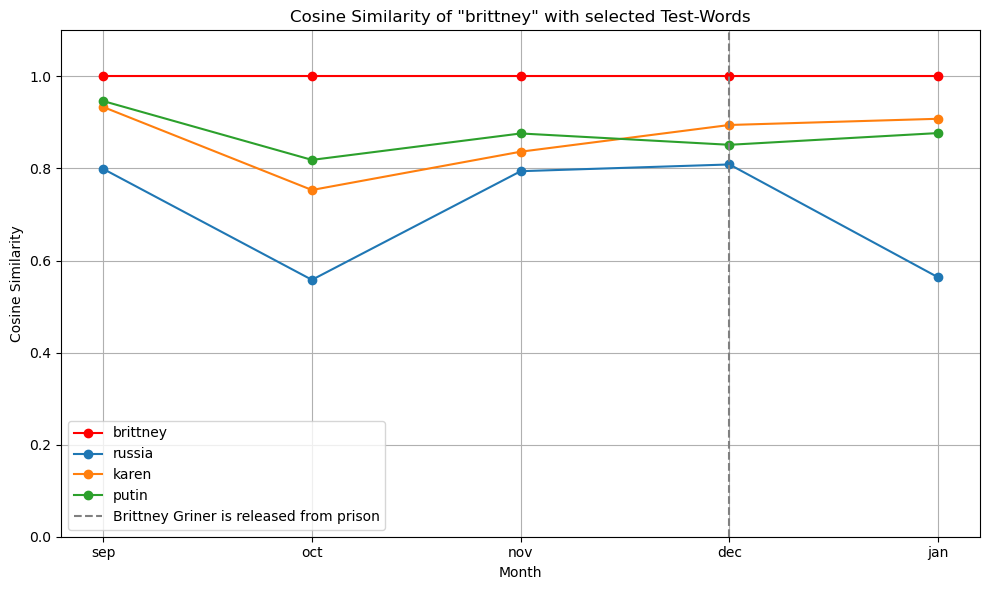

In [99]:
plot_cosine_similarity(target_word_griner, test_words_griner, selected_models_monthly_griner, event="dec", event_name="Brittney Griner is released from prison")

### TPPMI

In [100]:
target_word_griner = "brittney"
selected_months = [6, 7, 8]
tppmi_griner = tppmi_model.get_tppmi(test_words_griner + [target_word_griner], selected_months=selected_months)

All words are contained in the vocabulary
putin - not in vocab of timestep: 07
brittney - not in vocab of timestep: 06
brittney - not in vocab of timestep: 07
brittney - not in vocab of timestep: 08


In [101]:
test_words_griner = ["putin", "victor"]
plot_word_vectors_tppmi(tppmi_model.get_2d_representation([target_word_griner] + test_words_griner, selected_months=selected_months, use_tsne=False))

All words are contained in the vocabulary
brittney - not in vocab of timestep: 06
brittney - not in vocab of timestep: 07
brittney - not in vocab of timestep: 08
putin - not in vocab of timestep: 07
victor - not in vocab of timestep: 06
victor - not in vocab of timestep: 08


In [102]:
#plot_cosine_similarity_tppmi(target_word_griner, test_words_griner, tppmi_model, selected_months)

## Elon Musk Twitter takeover

### Overview

Business magnate Elon Musk initiated an acquisition of American social media company Twitter, Inc. on April 14, 2022, and concluded it on October 27, 2022. Musk had begun buying shares of the company in January 2022, becoming its largest shareholder by April with a 9.1 percent ownership stake

source: [Wikipedia article](https://en.wikipedia.org/wiki/Acquisition_of_Twitter_by_Elon_Musk#:~:text=Business%20magnate%20Elon%20Musk%20initiated,a%209.1%20percent%20ownership%20stake.)

In [103]:
target_word_twitter = "twitter"

In [104]:
selected_months_twitter = ["sep", "oct", "nov", "dec"]
selected_models_monthly_twitter = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_twitter}

In [105]:
title_twitter = f"Evolution of the word {target_word_twitter} over time"
subtitle_twitter = f"Period: {' - '.join([month.capitalize() for month in selected_months_twitter])}"

In [106]:
print_most_similar_cade(selected_models_monthly_twitter, target_word_twitter)

Word: twitter
Month: Sep
[('facebook', 0.9325878024101257), ('tweet', 0.8852959871292114), ('page', 0.8597615957260132)]
--------------------------------
Month: Oct
[('facebook', 0.9247101545333862), ('instagram', 0.806344747543335), ('sms', 0.7980491518974304)]
--------------------------------
Month: Nov
[('facebook', 0.8923001289367676), ('page', 0.7984558939933777), ('text', 0.7902756333351135)]
--------------------------------
Month: Dec
[('facebook', 0.8520953059196472), ('musk', 0.8208754658699036), ('tweet', 0.7895939350128174)]
--------------------------------


### Temporaly changing embeddings

In [107]:
plot_temporal_changing_embedding(target_word_twitter, selected_models_monthly_twitter, top_n=2, title=title_twitter, subtitle=subtitle_twitter, use_tsne=True)

### Cosine similarities

In [108]:
test_words_twitter = ["facebook",  "elon", "blue", "liberal"]

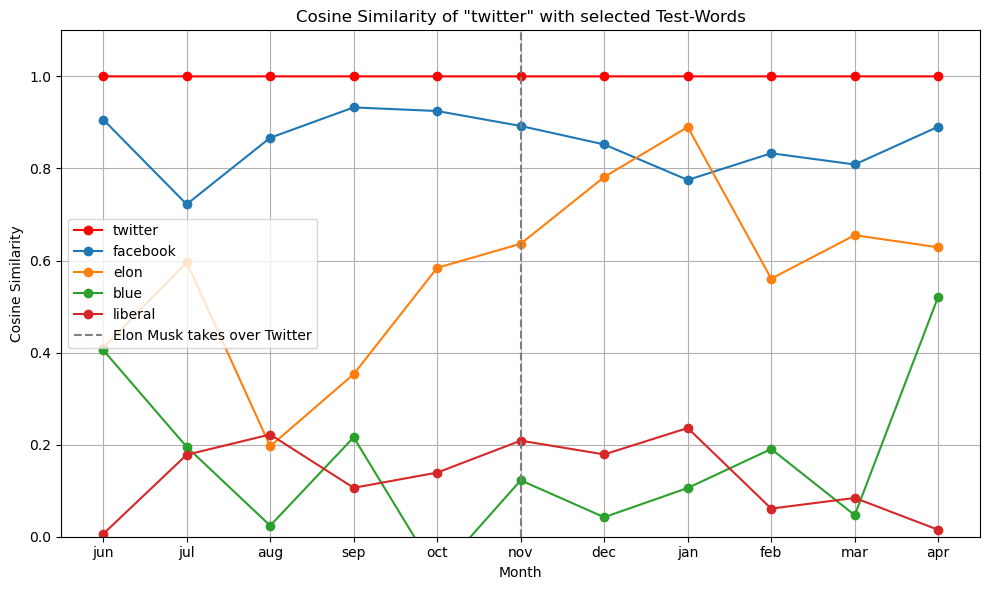

In [109]:
plot_cosine_similarity(target_word_twitter, test_words_twitter, models_monthly, "nov", "Elon Musk takes over Twitter")

### TPPMI

In [110]:
tppmi_twitter = tppmi_model.get_tppmi(test_words_twitter + [target_word_twitter])

All words are contained in the vocabulary
elon - not in vocab of timestep: 06
elon - not in vocab of timestep: 08
elon - not in vocab of timestep: 09


In [111]:
selected_months = [9, 10, 11, 12]
plot_word_vectors_tppmi(tppmi_model.get_2d_representation(test_words_twitter + [target_word_twitter], selected_months=None, use_tsne=False))

All words are contained in the vocabulary
elon - not in vocab of timestep: 06
elon - not in vocab of timestep: 08
elon - not in vocab of timestep: 09


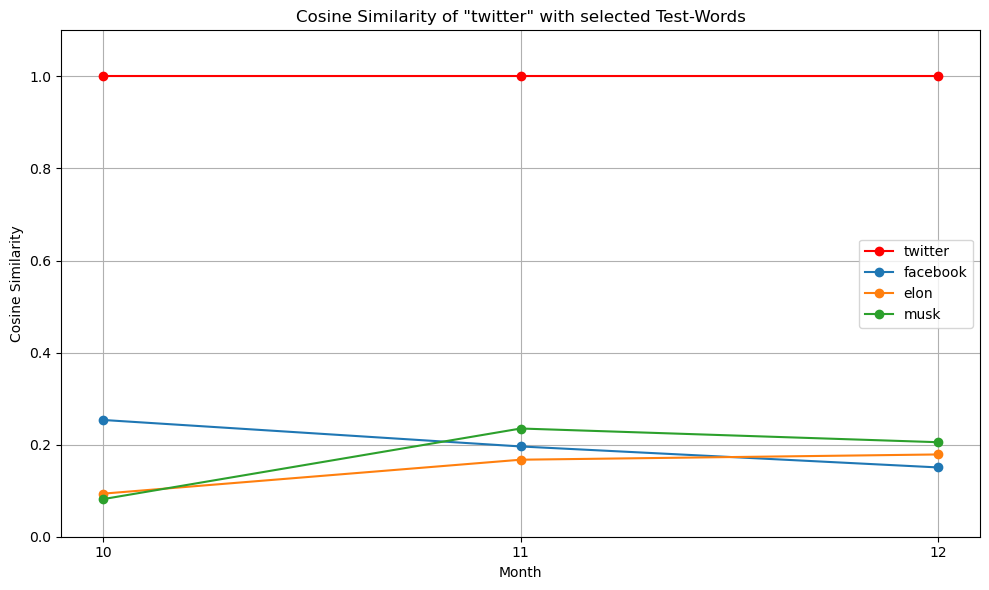

In [112]:
plot_cosine_similarity_tppmi("twitter", ["facebook", "elon", "musk"], tppmi_model, selected_months = [10, 11, 12])

## Attack on Paul Pelosi

### Overview

On October 28, 2022, an intruder attacked Paul Pelosi, the 82-year-old husband of Nancy Pelosi, then the Speaker of the United States House of Representatives. The assailant beat Paul Pelosi with a hammer during a home invasion burglary of the couple's residence in Pacific Heights, San Francisco. He was seriously injured and underwent surgery for his fractured skull.

source: [Wikipedia article](https://en.wikipedia.org/wiki/Attack_on_Paul_Pelosi)

In [ ]:
target_word_pelosi = "paul"

In [ ]:
selected_months_pelosi = ["oct", "nov", "dec", "jan"]
selected_models_monthly_pelosi = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_pelosi}

In [ ]:
title_pelosi = f"Evolution of the word {target_word_pelosi} over time"
subtitle_pelosi = f"Period: {' - '.join([month.capitalize() for month in selected_months_pelosi])}"

In [ ]:
print_most_similar_cade(selected_models_monthly_pelosi, target_word_pelosi, top_n = 4)

### Temporally changing embeddings

In [ ]:
plot_temporal_changing_embedding(target_word_pelosi, selected_models_monthly_pelosi, top_n=3, title=title_pelosi, subtitle=subtitle_pelosi, use_tsne=True)

### Cosine similarities

In [ ]:
print_most_similar_cade(models_monthly, target_word_pelosi)

In [ ]:
test_words_pelosi = ["attack", "democrats", "invasion", "hammer", "intruder"]

In [ ]:
plot_cosine_similarity(target_word_pelosi, test_words_pelosi, models_monthly, event="nov", event_name="Attack on Paul Pelosi")

### TPPMI

In [ ]:
tppmi_pelosi = tppmi_model.get_tppmi(test_words_pelosi + [target_word_pelosi])

In [ ]:
test_words_pelosi = ["attack", "democrats", "invasion"]
selected_months_pelosi = [10, 11, 12]
plot_word_vectors_tppmi(tppmi_model.get_2d_representation(test_words_pelosi + [target_word_pelosi], use_tsne=False, selected_months = selected_months_pelosi))

In [ ]:
plot_cosine_similarity_tppmi(target_word_pelosi, test_words_pelosi, tppmi_model, selected_months = selected_months_pelosi)

## Colorado Springs shooting at LGBTQ nightclub

### Overview

On November 19–20, 2022, an anti-LGBT-motivated mass shooting occurred at Club Q, a gay bar in Colorado Springs, Colorado, United States. Five people were murdered, and 25 others were injured, 19 of them by gunfire. The shooter, 22-year-old Anderson Lee Aldrich, was also injured while being restrained, and was taken to a local hospital

source: [wikipedia article](https://en.wikipedia.org/wiki/Colorado_Springs_nightclub_shooting)

In [ ]:
target_word_colorado_springs = "nightclub"

In [ ]:
selected_months_colorado_springs = ["oct", "nov", "dec", "jan"]
selected_models_monthly_colorado_springs = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_colorado_springs}

In [ ]:
title_colorado_springs = f"Evolution of the word {target_word_colorado_springs} over time"
subtitle_colorado_springs = f"Period: {' - '.join([month.capitalize() for month in selected_months_colorado_springs])}"

In [ ]:
print_most_similar_cade(selected_models_monthly_colorado_springs, target_word_colorado_springs)

### Temporarily changing embeddings

In [ ]:
plot_temporal_changing_embedding(target_word_colorado_springs, selected_models_monthly_colorado_springs,
                                 top_n=4, title=title_colorado_springs, subtitle=subtitle_colorado_springs, use_tsne=True)

### Cosine similarities

In [ ]:
test_words_colorado_springs = ["music", "gunman", "massacre"]

In [ ]:
plot_cosine_similarity(target_word_colorado_springs, test_words_colorado_springs, selected_models_monthly_colorado_springs, event="dec", event_name="Colorado Springs nightclub shooting")

### TPPMI

In [ ]:
tppmi_colorado_springs = tppmi_model.get_tppmi(test_words_colorado_springs + [target_word_colorado_springs])

In [ ]:
target_word_colorado_springs = "colorado"
selected_months_colorado_springs = [9, 10, 11, 12]

In [ ]:
test_words_colorado_springs = ["massacre", "kansas"]
plot_word_vectors_tppmi(tppmi_model.get_2d_representation(test_words_colorado_springs + [target_word_colorado_springs], use_tsne=False, selected_months = selected_months_colorado_springs))